In [11]:
import joblib
import math
import numpy as np
import os
import pandas as pd

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import ( accuracy_score, f1_score, r2_score, mean_squared_error )
from sklearn.model_selection import ( GridSearchCV, train_test_split )
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import( OneHotEncoder, StandardScaler, LabelEncoder )
from sklearn.utils import shuffle

In [12]:
numVotes = [200, 20000]
duree = [40, 150]
year = [1930, 2017]
genre = 8
parentalAdvisor = 5

In [13]:
dataset = pd.read_csv(r'src/dataset.csv', delimiter=',', on_bad_lines='skip')

corr_matrix = round(dataset.corr(), 4)

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.values.tolist(),
                                  y = corr_matrix.index.values.tolist(),
                                  )

fig.show()

# numVotes

In [14]:
print(len(dataset))

dfnumVotes = dataset.sort_values(by=['numVotes'])

dfnumVotes = dfnumVotes[dfnumVotes['numVotes'] < numVotes[1]]
dfnumVotes = dfnumVotes[dfnumVotes['numVotes'] > numVotes[0]]

print(len(dfnumVotes))

px.histogram(dfnumVotes["numVotes"])

88648
47417


# duree

In [15]:
dfduree = dfnumVotes.sort_values(by=['duree'])
dfduree = dfduree[dfduree['duree'] < duree[1]]
dfduree = dfduree[dfduree['duree'] > duree[0]]



print(len(dfduree))

px.histogram(dfduree["duree"])

45780


# year

In [16]:
dfyear = dfduree.sort_values(by=['year'])
dfyear = dfyear[dfyear['year'] < year[1]]
dfyear = dfyear[dfyear['year'] > year[0]]

print(len(dfyear))

px.histogram(dfyear["year"])

38592


# genre

29239


<AxesSubplot:>

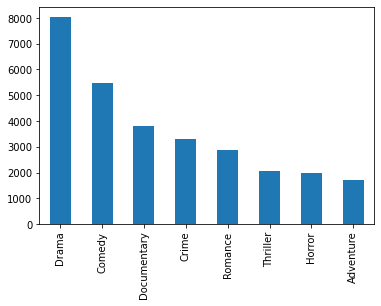

In [17]:
dfgenre = dfyear
countGenre = dfgenre['genre'].value_counts()
countGenre = countGenre[countGenre[:] > countGenre[genre] ]
listGenre = countGenre.keys().tolist()

dfgenre = dfgenre[dfgenre['genre'].isin(listGenre)]

print(len(dfgenre))

countGenre.plot(kind='bar')

# parentalAdvisor

Not Rated    8316
R            7877
PG           2096
Approved     2031
PG-13        1904
Name: parentalAdvisor, dtype: int64
22224


<AxesSubplot:>

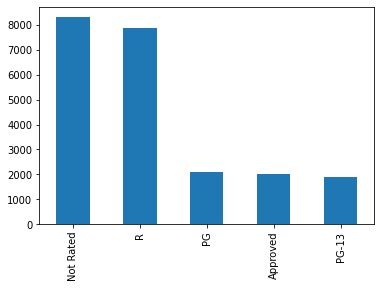

In [18]:
dfparentalAdvisor = dfgenre
countAdvisor = dfparentalAdvisor['parentalAdvisor'].value_counts()

countAdvisor = countAdvisor[countAdvisor[:] > countAdvisor[parentalAdvisor] ] # Drop Less than 5% of biggest genre.
print(countAdvisor)
listGenre = countAdvisor.keys().tolist()

dfparentalAdvisor = dfparentalAdvisor[dfparentalAdvisor['parentalAdvisor'].isin(listGenre)]

print(len(dfparentalAdvisor))

countAdvisor.plot(kind='bar')

# imdbRating

In [19]:
dfimdbRating = dfparentalAdvisor.sort_values(by=['imdbRating'])

print(len(dfimdbRating))

px.histogram(dfimdbRating["imdbRating"])

22224


# Drop Lines 

In [20]:
datasetWithoutOutlier = dfimdbRating.drop(columns=['tconst', 'numVotes'])
datasetWithoutOutlier = shuffle(datasetWithoutOutlier)

datasetWithoutOutlier.to_csv(r'export/datasetWithoutOutlier.csv', index = False, header=True)

In [21]:
target_name = 'imdbRating'

## Graph de correlation 

In [22]:


corr_matrix = round(datasetWithoutOutlier.corr(), 4)

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.values.tolist(),
                                  y = corr_matrix.index.values.tolist(),
                                  )


fig.show()

## Separation Varibles / Target

In [23]:
## Separation valeurs explicative et valeur cible
Y = datasetWithoutOutlier[:][target_name]
X = datasetWithoutOutlier.drop(columns= [target_name])

## Separation en train/test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=0, stratify=X['genre'])
# stratify = Y # option pour même ratio de réponse que sur la table Y.
print(X)
print(Y)

       year   genre parentalAdvisor  duree  themaScore
52049  1941  Comedy        Approved   82.0    0.210206
75906  1964  Comedy        Approved   89.0    0.137072
25575  2011  Comedy       Not Rated  125.0    0.284046
41586  1977  Horror       Not Rated   89.0    0.237045
56433  1973  Horror       Not Rated   89.0    0.197057
...     ...     ...             ...    ...         ...
73835  1964  Comedy       Not Rated   99.0    0.145667
14304  1998   Drama       Not Rated  100.0    0.317320
19866  2016   Crime       Not Rated   95.0    0.303908
88329  2015   Drama               R   92.0    0.023407
34960  1989  Horror               R   87.0    0.252379

[22224 rows x 5 columns]
52049    6.6
75906    5.1
25575    8.0
41586    5.7
56433    4.8
        ... 
73835    6.7
14304    7.1
19866    5.9
88329    5.3
34960    4.4
Name: imdbRating, Length: 22224, dtype: float64


## Pipeline Préprocessor 

In [24]:
## Médiane quantitative & plus fréquent qualitatif



# Create pipeline for numeric features
numeric_features = X.select_dtypes([np.number]).columns # Automatically detect positions of numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_features = X.select_dtypes("object").columns # Automatically detect positions of categorical columns
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train) # Preprocessing influenceur
X_test = preprocessor.transform(X_test) # Preprocessing copieur


## Training
### Random Forest

In [25]:
model = RandomForestRegressor(n_jobs=-1, verbose=2) 
# n_jobs=-1 -> Utilisation de tout les cores 
# verbose=2 -> Affiche toutes les info de constructions

## Prediction
### Random Forest model : Grid search

In [26]:

# Grid of values to be tested

params = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [10, 20, 40, 60, 80, 100]
}
'''
params = {
    'max_depth': [4, 6, 8, 10, 12, 14],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 5, 7, 10],
    'min_samples_split': [2, 4, 8, 16, 32, 64],
    'n_estimators': [10, 20, 40, 60, 80, 100, 200]
}
'''
gridsearch = GridSearchCV(model, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
# 36m 6.5s 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    6.5s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

building tree 1 of 100building tree 2 of 100

building tree 3 of 100building tree 4 of 100

building tree 5 of 100building tree 6 of 100
building tree 7 of 100

building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100building tree 14 of 100building tree 15 of 100


building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100building tree 20 of 100

building tree 21 of 100building tree 22 of 100

building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100building tree 28 of 100

building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100building tree 35 of 100

building tree 36 of 100building tree 37 of 100
building tree 38 of 100building tree 39 of 100


building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.2s


building tree 41 of 100
building tree 42 of 100building tree 43 of 100

building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100building tree 48 of 100

building tree 49 of 100
building tree 50 of 100building tree 51 of 100
building tree 52 of 100

building tree 53 of 100building tree 54 of 100

building tree 55 of 100building tree 56 of 100

building tree 57 of 100
building tree 58 of 100building tree 59 of 100building tree 60 of 100building tree 61 of 100



building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100building tree 68 of 100

building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100building tree 78 of 100

building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, verbose=2),
             param_grid={'max_depth': [4, 6, 8, 10],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [10, 20, 40, 60, 80, 100]})

In [27]:
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)

...Done.
Best hyperparameters :  {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [28]:
Y_train_pred = gridsearch.predict(X_train) # Predictions on training set
Y_test_pred = gridsearch.predict(X_test) # Prédictions on test set 

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


#### Grid search : Random Forest

In [29]:
# Compute mean squared error
mse = mean_squared_error(Y_test, Y_test_pred)
print("Mean squared error : ", mse)
print("Mean error : ", mse**0.5)


Mean squared error :  1.2526706278170905
Mean error :  1.1192276925706808


In [30]:
print(f'Number of votes min : {numVotes[0]}, max : {numVotes[1]}')
print(f'Duration min : {duree[0]}, max : {duree[1]}')
print(f'From {year[0]} to {year[1]}')
print(f'{genre} best genres selected')
print(f'{parentalAdvisor} best advisory selected')


fig = px.scatter(x = Y_test, y = Y_test_pred, opacity=0.2, trendline="lowess", width=650, height=600, marginal_y='violin')
fig.update_layout( margin=dict(l=20, r=10, t=10, b=10), yaxis=dict(scaleanchor="x", scaleratio=1))
fig.show()

Number of votes min : 200, max : 20000
Duration min : 40, max : 150
From 1930 to 2017
8 best genres selected
5 best advisory selected


In [31]:
def ecartExponantiel(chiffre, moyenne): 
    returnValue = moyenne

    if chiffre == moyenne:
        returnValue = chiffre

    elif chiffre > moyenne:
        ecart = chiffre-moyenne
        logy = math.log1p( ecart + 1) 
        returnValue = chiffre + (ecart * logy)

    else :
        ecart = moyenne-chiffre
        logy = math.log1p( ecart + 0.5)
        
        returnValue = chiffre - (ecart * logy)

    if returnValue > 10:
        return 10
    elif returnValue < 0:
        return 0
    else:
        return returnValue

In [32]:
Y_test_pred2 = np.array([ecartExponantiel(num,Y_test_pred.mean()) for num in Y_test_pred])


fig = px.scatter(x = Y_test, y = Y_test_pred2, opacity=0.2, trendline="lowess", width=600, height=600)
fig.update_layout( 
    margin=dict(l=20, r=10, t=10, b=10),
    xaxis=go.layout.XAxis(range=[0, 10]),
    yaxis=go.layout.YAxis(range=[0, 10]),

)
fig.show()


In [33]:
navet_vs_hits = pd.DataFrame(columns= ['Reel', 'Estimation'])

navet_vs_hits['Reel'] = Y_test.tolist()
navet_vs_hits['Estimation'] = Y_test_pred2.tolist()
navet_vs_hits['ecart'] = navet_vs_hits.apply(lambda x: abs(x['Reel'] - x['Estimation']), axis = 1)

navet_vs_hits

fig = px.scatter(x =navet_vs_hits['Reel'], y =navet_vs_hits['Estimation'], color=navet_vs_hits['ecart'], opacity=0.2, trendline="lowess", width=600, height=600)
fig.update_layout( 
    margin=dict(l=20, r=10, t=10, b=10),
    xaxis=go.layout.XAxis(range=[0, 10]),
    yaxis=go.layout.YAxis(range=[0, 10]),

)
fig.show()

In [34]:
navet_vs_hits = pd.DataFrame(columns= ['Reel', 'Estimation'])

navet_vs_hits['Reel'] = Y_test.tolist()
navet_vs_hits['Estimation'] = Y_test_pred.tolist()
navet_vs_hits['ecart'] = navet_vs_hits.apply(lambda x: abs(x['Reel'] - x['Estimation']), axis = 1)

hits = navet_vs_hits[navet_vs_hits['Reel'] > 7.5]
navet = navet_vs_hits[navet_vs_hits['Reel'] < 3]

navet_vs_hits = hits.append(navet)

fig = px.scatter(x =navet_vs_hits['Reel'], y =navet_vs_hits['Estimation'], color=navet_vs_hits['ecart'], opacity=1, width=600, height=600)
fig.update_layout( 
    margin=dict(l=20, r=10, t=10, b=10),
    xaxis=go.layout.XAxis(range=[0, 10]),
    yaxis=go.layout.YAxis(range=[0, 10]),

)
fig.show()

<ipython-input-34-1a01a0f0c34d>:10: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [35]:
navet_vs_hits = pd.DataFrame(columns= ['Reel', 'Estimation'])

navet_vs_hits['Reel'] = Y_test.tolist()
navet_vs_hits['Estimation'] = Y_test_pred.tolist()
navet_vs_hits['ecart'] = navet_vs_hits.apply(lambda x: abs(x['Reel'] - x['Estimation']), axis = 1)

moyenneH = navet_vs_hits[navet_vs_hits['Reel'] < 8.5]
moyenneH = moyenneH[moyenneH['Reel'] > 5.8878706275296135 ]

fig = px.scatter(x =moyenneH['Reel'], y =moyenneH['Estimation'], color=moyenneH['ecart'], opacity=1, width=600, height=600)
fig.update_layout( 
    margin=dict(l=20, r=10, t=10, b=10),
    xaxis=go.layout.XAxis(range=[0, 10]),
    yaxis=go.layout.YAxis(range=[0, 10]),

)
fig.show()

In [36]:
navet_vs_hits = pd.DataFrame(columns= ['Reel', 'Estimation'])

navet_vs_hits['Reel'] = Y_test.tolist()
navet_vs_hits['Estimation'] = Y_test_pred.tolist()
navet_vs_hits['ecart'] = navet_vs_hits.apply(lambda x: abs(x['Reel'] - x['Estimation']), axis = 1)

moyenneH = navet_vs_hits[navet_vs_hits['Reel'] > 3]
moyenneH = moyenneH[moyenneH['Reel'] < 5.8878706275296135 ]

fig = px.scatter(x =moyenneH['Reel'], y =moyenneH['Estimation'], color=moyenneH['ecart'], opacity=1, width=600, height=600)
fig.update_layout( 
    margin=dict(l=20, r=10, t=10, b=10),
    xaxis=go.layout.XAxis(range=[0, 10]),
    yaxis=go.layout.YAxis(range=[0, 10]),

)
fig.show()

In [37]:
# Moyenne des films : 5.8878706275296135       Y_test_pred.mean() 

# Dans les très bons films au dela de 8,5
# 5,8754 à 7,5004

# Dans les films moyen de (5.8878706275296135) à 8,5
# 4,6098 & 7,5712 

# Dans les films moyen de 3 à (5.8878706275296135)
# 4,4394 & 7,2214 

# Dans les pires films en desous de 3
# 4,5842 & 6,2987


In [38]:
#### Classification par moyenne

# Excellent : 6.6879 à 10 --------- 6.7 à 10
# Bon : 6.0905 à 6.6879 ----------- 6.1 à 6.7
# Sans avis : 5.8304 à 6.0905 ----- 5.8 à 6.1
# Pas top : 5.4415 à 5.8304 ------- 5.4 à 5.8
# Navet : 0 à 5.4415 -------------- 0 à 5.4

#### Classification par exclusion 

# Excellent : 6,2987 et ++
# À Voir : 5,8754 à 6,2987
# Navet : 5,8754 et -- 

## Save Model

In [39]:
# save
joblib.dump(gridsearch.best_estimator_, "export/random_forest.joblib", compress=3)

['export/random_forest.joblib']